<a href="https://colab.research.google.com/github/mskansara/airline_prediction/blob/master/Airline_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

29
Epoch 1/10
113/113 - 2s - loss: 0.0318
Epoch 2/10
113/113 - 0s - loss: 0.0140
Epoch 3/10
113/113 - 0s - loss: 0.0114
Epoch 4/10
113/113 - 0s - loss: 0.0098
Epoch 5/10
113/113 - 0s - loss: 0.0083
Epoch 6/10
113/113 - 0s - loss: 0.0069
Epoch 7/10
113/113 - 0s - loss: 0.0058
Epoch 8/10
113/113 - 0s - loss: 0.0047
Epoch 9/10
113/113 - 0s - loss: 0.0041
Epoch 10/10
113/113 - 0s - loss: 0.0035
Train Score: 29.69 RMSE
Test Score: 64.59 RMSE


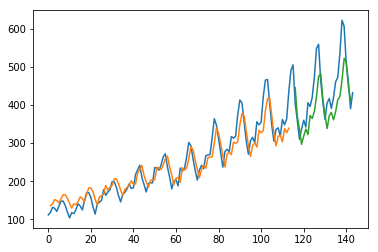

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

np.random.seed(7)

#Import the dataset 
dataframe = pd.read_csv("airline-passengers.csv", usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

#Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

#Split into train and test data
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(test))

#convert an array of values into dataset
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#create and fit the lstm network
model = Sequential()
model.add(LSTM(4, input_shape=(1,look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY,epochs=10,batch_size=1, verbose=2)

#make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

#invert prediction
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

#calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()